# 1. Dataset for emotion prediction

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import numpy as np
import pandas as pd
import pickle
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hoc13\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

'0': sadness
               '1': joy
               '2': love
               '3': anger
               '4': fear
               '5': surprise

In [6]:
dataset = load_dataset('json', data_files={'train': 'train.jsonl','test':'validation.jsonl'})

vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])

vocabulary = vectorizer.get_feature_names_out()

tfidf = TfidfTransformer()

X_train_idf = tfidf.fit_transform(X_train_vec)

X_test_vec = vectorizer.transform(dataset['test']['text'])

X_test_idf = tfidf.transform(X_test_vec)

X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()

X_train, X_test, y_train, y_test = X_train,X_test,dataset['train']['label'], dataset['test']['label']

Generating train split: 16000 examples [00:00, 579208.76 examples/s]
Generating test split: 2000 examples [00:00, 160188.82 examples/s]


# 3. Blending

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

n_estimators_list = [2, 6, 8, 16]
max_depth_list = [2, 4, 6, 8, 16]

def make_blending_prediction(basic_clfs, final_clf, data):
    predictions = np.array([clf.predict(data) for clf in basic_clfs]).T
    return final_clf.predict(predictions)

def train_classifiers(X_train_0, y_train_0, X_train_1, y_train_1, n_estimators, max_depth, min_samples_split, min_samples_leaf):
    classifiers = []
    predictions = []

    for n in range(1, 11):
        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=n
        )
        clf.fit(X_train_0, y_train_0)
        classifiers.append(clf)
        predictions.append(clf.predict(X_train_1).reshape(-1, 1))

    return classifiers, np.hstack(predictions)

def evaluate_model(X_train_0, y_train_0, X_train_1, y_train_1, X_test, y_test):
    results = []
    n_estimators_list = [2, 6, 8, 16]
    max_depth_list = [2, 4, 6, 8, 16]
    min_samples_split_list = [2, 6, 8, 12]
    min_samples_leaf_list = [1, 2, 4, 6]
    for max_depth in max_depth_list:
        for n_estimators in n_estimators_list:
            for min_samples_split in min_samples_split_list:
                for min_samples_leaf in min_samples_leaf_list:
                    classifiers, predictions_transposed = train_classifiers(X_train_0, y_train_0, X_train_1, y_train_1, n_estimators, max_depth, min_samples_split, min_samples_leaf)

                    clf_final = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
                    clf_final.fit(predictions_transposed, y_train_1)

                    y_test_pred = make_blending_prediction(classifiers, clf_final, X_test)
                    acc = accuracy_score(y_test, y_test_pred)

                    results.append((n_estimators, max_depth, min_samples_split, min_samples_leaf, acc))

    return results

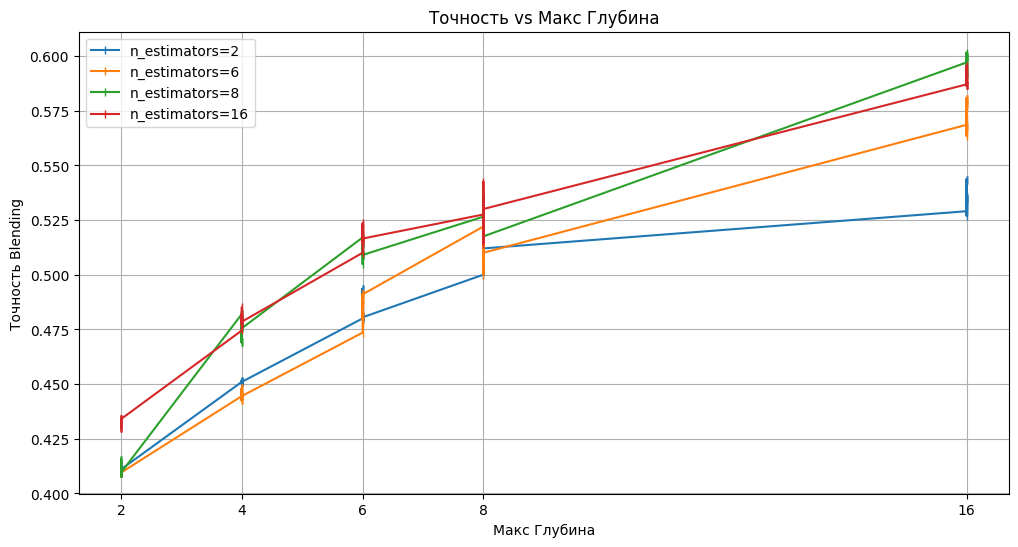

In [8]:
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

results = evaluate_model(X_train_0, y_train_0, X_train_1, y_train_1, X_test, y_test)
results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'accuracy'])

plt.figure(figsize=(12, 6))
for n_estimators in n_estimators_list:
    subset = results_df[results_df['n_estimators'] == n_estimators]
    plt.plot(subset['max_depth'], subset['accuracy'], marker='|', linestyle='-', label=f'n_estimators={n_estimators}')

plt.title('Точность vs Макс Глубина')
plt.xlabel('Макс Глубина')
plt.ylabel('Точность Blending')
plt.xticks(max_depth_list)
plt.legend()
plt.grid()
plt.show()

# 4. Stacking

In [11]:
def make_stacking_prediction(basic_clfs, final_clf, data):
    predictions = np.array([clf.predict(data) for clf in basic_clfs]).T
    return final_clf.predict(predictions)

def train_base_classifiers(X_train_0, y_train_0, X_train_1, max_depth, min_samples_split, min_samples_leaf, n_estimators):
    classifiers = []
    predictions = []

    for n in range(1, 11):
        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=n
        )
        clf.fit(X_train_0, y_train_0)
        classifiers.append(clf)
        predictions.append(clf.predict(X_train_1).reshape(-1, 1))

    return classifiers, np.hstack(predictions)

def evaluate_stacking_model(X_train_0, y_train_0, X_train_1, y_train_1, X_test, y_test):
    results = []
    n_estimators_list = [2, 6, 12]
    max_depth_list = [2, 4, 10]
    min_samples_split_list = [2, 6, 12]
    min_samples_leaf_list = [1, 2, 6]
    C_list = [0.1, 1, 10]
    solver_list = ['liblinear', 'saga']

    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                for min_samples_leaf in min_samples_leaf_list:
                    classifiers, predictions_transposed = train_base_classifiers(X_train_0, y_train_0, X_train_1, max_depth, min_samples_split, min_samples_leaf, n_estimators)

                    for C in C_list:
                        for solver in solver_list:
                            clf_final = LogisticRegression(C=C, solver=solver, random_state=42, max_iter=500)
                            clf_final.fit(predictions_transposed, y_train_1)

                            y_test_pred = np.column_stack([clf.predict(X_test) for clf in classifiers])
                            final_predictions = clf_final.predict(y_test_pred)

                            acc = accuracy_score(y_test, final_predictions)
                            results.append((n_estimators, max_depth, min_samples_split, min_samples_leaf, acc))

    return results

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
results = evaluate_stacking_model(X_train_0, y_train_0, X_train_1, y_train_1, X_test, y_test)
results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'accuracy'])

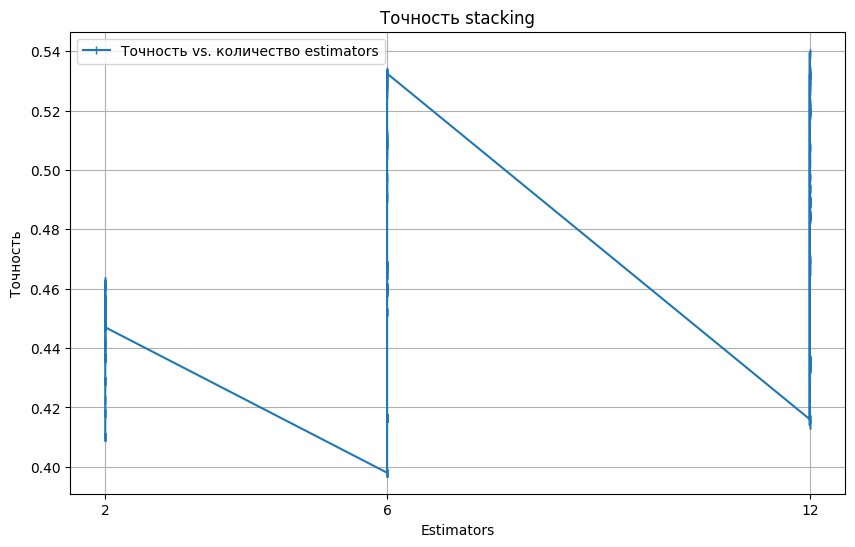

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_estimators'], results_df['accuracy'], marker='|', label='Точность vs. количество estimators')
plt.title('Точность stacking')
plt.xlabel('Estimators')
plt.ylabel('Точность')
plt.xticks(results_df['n_estimators'].unique())
plt.legend()
plt.grid()
plt.show()

## Trees

In [16]:
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()

X = iris.data[:, 2:]
y = iris.target

target_names = iris.target_names
feature_names = iris.feature_names[2:]

[Text(0.4, 0.8333333333333334, 'x[0] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[1] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

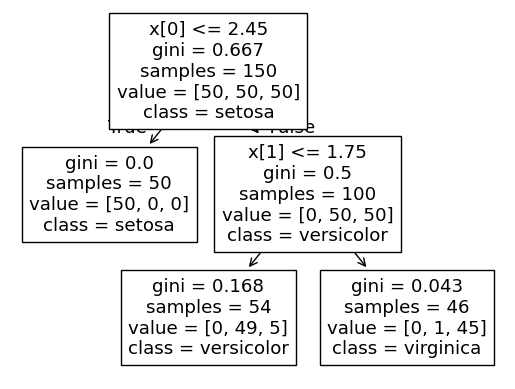

In [17]:
tree_clf_gini = DecisionTreeClassifier(criterion = 'gini',max_depth=2, random_state=42)
tree_clf_gini.fit(X, y)
tree.plot_tree(tree_clf_gini, class_names = iris.target_names)

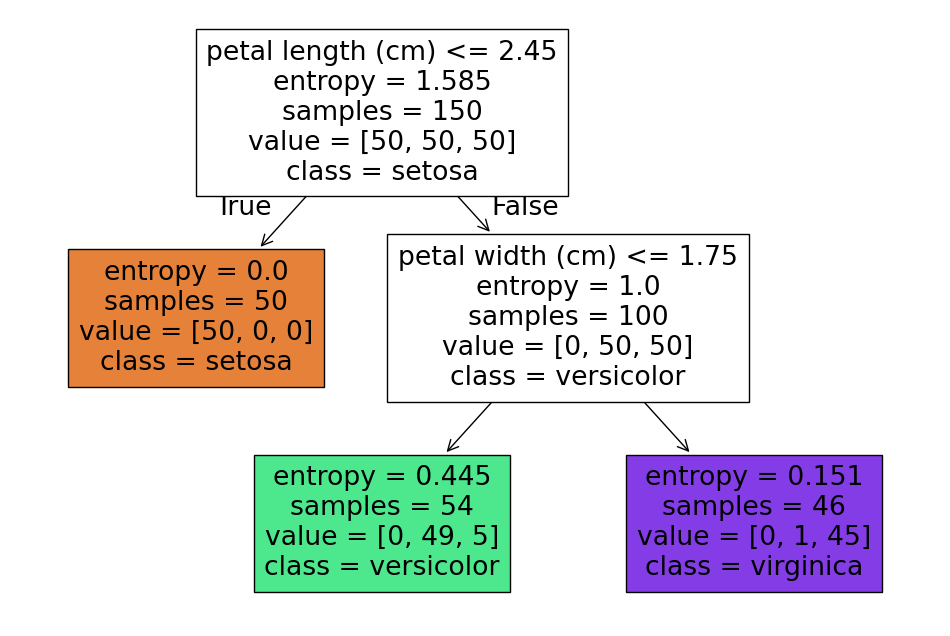

In [18]:
# Task
# criterion: “gini”, “entropy”. default=”gini”
# Задание: постройте и визуализируйте структуру решающего дерева
# для критерия разбиения “entropy"

tree_clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
tree_clf_entropy.fit(X, y)

plt.figure(figsize=(12, 8))
tree.plot_tree(tree_clf_entropy, feature_names=feature_names, class_names=target_names, filled=True)
plt.show()

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

train = pd.read_csv(r'departure-delayed\departure-delayed\train_features.csv').fillna(0)
y = pd.read_csv(r'departure-delayed\departure-delayed\train_target.csv', index_col='id')

train.drop('Year', axis=1, inplace=True)

real_columns = list(train.dtypes[train.dtypes != 'object'].index.values)

x_train, x_val, y_train, y_val = train_test_split(train[real_columns], y, train_size=0.8, test_size=0.2, random_state=42)

min_samples_leaf_values = [1, 2, 5, 10, 20, 100, 500]
mae_values = []
mae_train = []



In [26]:
for min_samples_leaf in min_samples_leaf_values:
    model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(x_train, y_train)
    mae_train.append(mean_absolute_error(y_train, model.predict(x_train)))
    mae_values.append(mean_absolute_error(y_val, model.predict(x_val)))

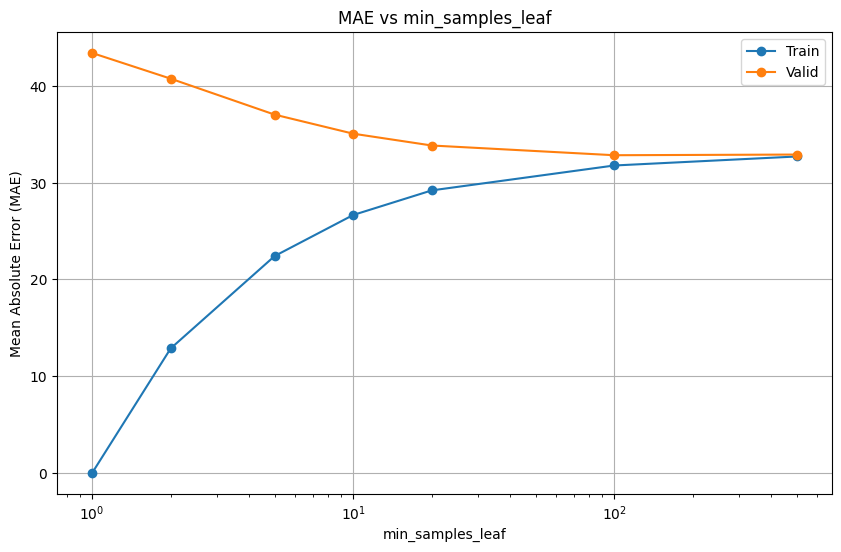

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, mae_train, label='Train', marker='o', linestyle='-')
plt.plot(min_samples_leaf_values, mae_values, label='Valid', marker='o', linestyle='-')
plt.title('MAE vs min_samples_leaf')
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.xscale('log')
plt.show()

In [28]:
# обучите дерево с наилучшими параметрами из предыдущего примера
best_model = DecisionTreeRegressor(max_depth=21, min_samples_leaf=500)
best_model.fit(x_train[real_columns], y_train)
mean_absolute_error(best_model.predict(x_train[real_columns]), y_train)

32.71719531317202

In [29]:
# Задача: выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor
# Выбрать оптимальные параметры для каждого дерева.
from sklearn.ensemble import BaggingRegressor

bag_trees = BaggingRegressor(best_model, n_estimators=5, random_state=42)
bag_trees.fit(x_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=21,
                                                 min_samples_leaf=500),
                 n_estimators=5, random_state=42)

In [30]:
from sklearn.model_selection import GridSearchCV

y_train_flat = y_train.values.ravel()

param_grid = {
    'n_estimators': [4, 6, 8],
    'max_samples': [0.4, 0.8, 1.0],
    'max_features': [0.4, 0.8, 1.0]
}

grid_search = GridSearchCV(bag_trees, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train_flat)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший MAE: {-grid_search.best_score_}')

Лучшие параметры: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 8}
Лучший MAE: 32.916907092923886


Задача: обучить, выявить оптимальное количество моделей в регрессоре, оптимальные параметры для регрессора

In [43]:
from sklearn.ensemble import RandomForestRegressor

forestReg = RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=42, criterion='squared_error', max_depth=9)
forestReg.fit(x_train, y_train)
rf_mse_val = mean_absolute_error(forestReg.predict(x_val), y_val)
rf_mse_val

param_grid = {
    'n_estimators': [4, 6, 8, 10],
    'max_depth': [None, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

forestReg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=forestReg, param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train[real_columns], y_train)

best_params = grid_search.best_params_
print("Лучшие параметры: ", best_params)
best_forest = grid_search.best_estimator_
y_pred = best_forest.predict(x_val[real_columns])

mae = mean_absolute_error(y_val, y_pred)

print("MAE: ", mae)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Лучшие параметры:  {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 8}
MAE:  33.39277241196768
